In [17]:
import os
import json
import numpy as np
import theano
import theano.tensor as T
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.utils import shuffle
from word2vec import get_wikipedia_data,  get_sentences_with_word2idx_limit_vocab

In [25]:
def _find_analogies(w1, w2, w3, We, word2idx):
    king = We[word2idx[w1]]
    man = We[word2idx[w2]]
    woman = We[word2idx[w3]]
    v0 = king - man + woman

    def dist1(a, b):
        return np.linalg.norm(a - b)
    def dist2(a, b):
        return 1 - a.dot(b) / (np.linalg.norm(a) * np.linalg.norm(b))

    for dist, name in [(dist1, 'Euclidean'), (dist2, 'cosine')]:
        min_dist = float('inf')
        best_word = ''
        for word, idx in word2idx.items():
            if word not in (w1, w2, w3):
                v1 = We[idx]
                d = dist(v0, v1)
                if d < min_dist:
                    min_dist = d
                    best_word = word
        print ("closest match by", name, "distance:", best_word)
        print (w1, "-", w2, "=", best_word, "-", w3)

In [29]:
def find_analogies(w1, w2, w3, concat=True, we_file, w2i_file):
    npz = np.load(we_file)
    W1 = npz['arr_0']
    W2 = npz['arr_1']

    with open(w2i_file) as f:
        word2idx = json.load(f)

    V = len(word2idx)

    if concat:
        We = np.hstack([W1, W2.T])
        print ("We.shape:", We.shape)
        assert(V == We.shape[0])
    else:
        We = (W1 + W2.T) / 2

    _find_analogies(w1, w2, w3, We, word2idx)

SyntaxError: non-default argument follows default argument (<ipython-input-29-64a44d60b51a>, line 1)

In [ ]:
class Glove:
    def __init__(self, D, V, context_sz):
        self.D = D
        self.V = V
        self.context_sz = context_sz

    def fit(self, sentences, cc_matrix=None, learning_rate=1e-4, reg=0.1, xmax=100, alpha=0.75, epochs=10, gd=False, use_theano=False, use_tensorflow=False):
        # build co-occurrence matrix
        # paper calls it X, so we will call it X, instead of calling
        # the training data X
        # TODO: would it be better to use a sparse matrix?
        t0 = datetime.now()
        V = self.V
        D = self.D

        if not os.path.exists(cc_matrix):
            X = np.zeros((V, V))
            N = len(sentences)
            print ("number of sentences to process:", N)
            it = 0
            for sentence in sentences:
                it += 1
                if it % 10000 == 0:
                    print ("processed", it, "/", N)
                n = len(sentence)
                for i in range(n):
                    # i is not the word index!!!
                    # j is not the word index!!!
                    # i just points to which element of the sequence (sentence) we're looking at
                    wi = sentence[i]

                    start = max(0, i - self.context_sz)
                    end = min(n, i + self.context_sz)

                    # we can either choose only one side as context, or both
                    # here we are doing both

                    # make sure "start" and "end" tokens are part of some context
                    # otherwise their f(X) will be 0 (denominator in bias update)
                    if i - self.context_sz < 0:
                        points = 1.0 / (i + 1)
                        X[wi,0] += points
                        X[0,wi] += points
                    if i + self.context_sz > n:
                        points = 1.0 / (n - i)
                        X[wi,1] += points
                        X[1,wi] += points

                    # left side
                    for j in range(start, i):
                        wj = sentence[j]
                        points = 1.0 / (i - j) # this is +ve
                        X[wi,wj] += points
                        X[wj,wi] += points

                    # right side
                    for j in range(i + 1, end):
                        wj = sentence[j]
                        points = 1.0 / (j - i) # this is +ve
                        X[wi,wj] += points
                        X[wj,wi] += points

            # save the cc matrix because it takes forever to create
            np.save(cc_matrix, X)
        else:
            X = np.load(cc_matrix)

        print ("max in X:", X.max())

        # weighting
        fX = np.zeros((V, V))
        fX[X < xmax] = (X[X < xmax] / float(xmax)) ** alpha
        fX[X >= xmax] = 1

        print ("max in f(X):", fX.max())

        # target
        logX = np.log(X + 1)

        print ("max in log(X):", logX.max())

        print ("time to build co-occurrence matrix:", (datetime.now() - t0))

        # initialize weights
        W = np.random.randn(V, D) / np.sqrt(V + D)
        b = np.zeros(V)
        U = np.random.randn(V, D) / np.sqrt(V + D)
        c = np.zeros(V)
        mu = logX.mean()

        if use_theano:
            # initialize weights, inputs, targets placeholders
            thW = theano.shared(W)
            thb = theano.shared(b)
            thU = theano.shared(U)
            thc = theano.shared(c)
            thLogX = T.matrix('logX')
            thfX = T.matrix('fX')

            params = [thW, thb, thU, thc]

            thDelta = thW.dot(thU.T) + T.reshape(thb, (V, 1)) + T.reshape(thc, (1, V)) + mu - thLogX
            thCost = ( thfX * thDelta * thDelta ).sum()

            # regularization
            thCost += reg*( (thW * thW).sum() + (thU * thU).sum() + (thb * thb).sum() + (thc * thc).sum())

            grads = T.grad(thCost, params)

            updates = [(p, p - learning_rate*g) for p, g in zip(params, grads)]

            train_op = theano.function(
                inputs=[thfX, thLogX],
                updates=updates,
            )

        elif use_tensorflow:
            # initialize weights, inputs, targets placeholders
            tfW = tf.Variable(W.astype(np.float32))
            tfb = tf.Variable(b.reshape(V, 1).astype(np.float32))
            tfU = tf.Variable(U.astype(np.float32))
            tfc = tf.Variable(c.reshape(1, V).astype(np.float32))
            tfLogX = tf.placeholder(tf.float32, shape=(V, V))
            tffX = tf.placeholder(tf.float32, shape=(V, V))

            delta = tf.matmul(tfW, tf.transpose(tfU)) + tfb + tfc + mu - tfLogX
            cost = tf.reduce_sum(tffX * delta * delta)
            for param in (tfW, tfb, tfU, tfc):
                cost += reg*tf.reduce_sum(param * param)

            train_op = tf.train.MomentumOptimizer(learning_rate, momentum=0.9).minimize(cost)
            init = tf.global_variables_initializer()
            session = tf.InteractiveSession()
            session.run(init)

        costs = []
        sentence_indexes = range(len(sentences))
        for epoch in range(epochs):
            delta = W.dot(U.T) + b.reshape(V, 1) + c.reshape(1, V) + mu - logX
            cost = ( fX * delta * delta ).sum()
            costs.append(cost)
            print ("epoch:", epoch, "cost:", cost)

            if gd:
                # gradient descent method

                if use_theano:
                    train_op(fX, logX)
                    W = thW.get_value()
                    b = thb.get_value()
                    U = thU.get_value()
                    c = thc.get_value()

                elif use_tensorflow:
                    session.run(train_op, feed_dict={tfLogX: logX, tffX: fX})
                    W, b, U, c = session.run([tfW, tfb, tfU, tfc])

                else:
                    # update W
                    oldW = W.copy()
                    for i in range(V):
                        # for j in xrange(V):
                        #     W[i] -= learning_rate*fX[i,j]*(W[i].dot(U[j]) + b[i] + c[j] + mu - logX[i,j])*U[j]
                        W[i] -= learning_rate*(fX[i,:]*delta[i,:]).dot(U)
                    W -= learning_rate*reg*W
                    # print "updated W"

                    # update b
                    for i in range(V):
                        # for j in xrange(V):
                        #     b[i] -= learning_rate*fX[i,j]*(W[i].dot(U[j]) + b[i] + c[j] + mu - logX[i,j])
                        b[i] -= learning_rate*fX[i,:].dot(delta[i,:])
                    b -= learning_rate*reg*b
                    # print "updated b"

                    # update U
                    for j in range(V):
                        # for i in xrange(V):
                        #     U[j] -= learning_rate*fX[i,j]*(W[i].dot(U[j]) + b[i] + c[j] + mu - logX[i,j])*W[i]
                        U[j] -= learning_rate*(fX[:,j]*delta[:,j]).dot(oldW)
                    U -= learning_rate*reg*U
                    # print "updated U"

                    # update c
                    for j in range(V):
                        # for i in xrange(V):
                        #     c[j] -= learning_rate*fX[i,j]*(W[i].dot(U[j]) + b[i] + c[j] + mu - logX[i,j])
                        c[j] -= learning_rate*fX[:,j].dot(delta[:,j])
                    c -= learning_rate*reg*c
                    # print "updated c"

            else:
                # ALS method

                # update W
                # fast way
                # t0 = datetime.now()
                for i in range(V):
                    # matrix = reg*np.eye(D) + np.sum((fX[i,j]*np.outer(U[j], U[j]) for j in xrange(V)), axis=0)
                    matrix = reg*np.eye(D) + (fX[i,:]*U.T).dot(U)
                    # assert(np.abs(matrix - matrix2).sum() < 10e-5)
                    vector = (fX[i,:]*(logX[i,:] - b[i] - c - mu)).dot(U)
                    W[i] = np.linalg.solve(matrix, vector)
                # print "fast way took:", (datetime.now() - t0)

                # slow way
                # t0 = datetime.now()
                # for i in xrange(V):
                #     matrix2 = reg*np.eye(D)
                #     vector2 = 0
                #     for j in xrange(V):
                #         matrix2 += fX[i,j]*np.outer(U[j], U[j])
                #         vector2 += fX[i,j]*(logX[i,j] - b[i] - c[j])*U[j]
                # print "slow way took:", (datetime.now() - t0)

                    # assert(np.abs(matrix - matrix2).sum() < 10e-5)
                    # assert(np.abs(vector - vector2).sum() < 10e-5)
                    # W[i] = np.linalg.solve(matrix, vector)
                # print "updated W"

                # update b
                for i in range(V):
                    denominator = fX[i,:].sum()
                    # assert(denominator > 0)
                    numerator = fX[i,:].dot(logX[i,:] - W[i].dot(U.T) - c - mu)
                    # for j in xrange(V):
                    #     numerator += fX[i,j]*(logX[i,j] - W[i].dot(U[j]) - c[j])
                    b[i] = numerator / denominator / (1 + reg)
                # print "updated b"

                # update U
                for j in range(V):
                    # matrix = reg*np.eye(D) + np.sum((fX[i,j]*np.outer(W[i], W[i]) for i in xrange(V)), axis=0)
                    matrix = reg*np.eye(D) + (fX[:,j]*W.T).dot(W)
                    # assert(np.abs(matrix - matrix2).sum() < 10e-8)
                    vector = (fX[:,j]*(logX[:,j] - b - c[j] - mu)).dot(W)
                    # matrix = reg*np.eye(D)
                    # vector = 0
                    # for i in xrange(V):
                    #     matrix += fX[i,j]*np.outer(W[i], W[i])
                    #     vector += fX[i,j]*(logX[i,j] - b[i] - c[j])*W[i]
                    U[j] = np.linalg.solve(matrix, vector)
                # print "updated U"

                # update c
                for j in range(V):
                    denominator = fX[:,j].sum()
                    numerator = fX[:,j].dot(logX[:,j] - W.dot(U[j]) - b  - mu)
                    # for i in xrange(V):
                    #     numerator += fX[i,j]*(logX[i,j] - W[i].dot(U[j]) - b[i])
                    c[j] = numerator / denominator / (1 + reg)
                # print "updated c"

        self.W = W
        self.U = U

        plt.plot(costs)
        plt.show()

    def save(self, fn):
        # function word_analogies expects a (V,D) matrx and a (D,V) matrix
        arrays = [self.W, self.U.T]
        np.savez(fn, *arrays)

max in X: 194664.84762
max in f(X): 1.0
max in log(X): 12.1790397657
time to build co-occurrence matrix: 0:00:02.860000
epoch: 0 cost: 926278.29206
epoch: 1 cost: 406004.531001
epoch: 2 cost: 575635.812685
epoch: 3 cost: 430903.217361
epoch: 4 cost: 439405.274157
epoch: 5 cost: 441729.168145
epoch: 6 cost: 391250.004177
epoch: 7 cost: 345239.725872
epoch: 8 cost: 260739.106723
epoch: 9 cost: 376216.800319


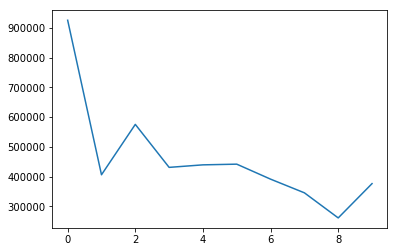

** concat: True
We.shape: (5001, 200)
closest match by Euclidean distance: apparent
king - man = apparent - woman
closest match by cosine distance: apparent
king - man = apparent - woman
We.shape: (5001, 200)
closest match by Euclidean distance: introduced
france - paris = introduced - london
closest match by cosine distance: sba
france - paris = sba - london
We.shape: (5001, 200)
closest match by Euclidean distance: fascinating
france - paris = fascinating - rome
closest match by cosine distance: fascinating
france - paris = fascinating - rome
We.shape: (5001, 200)
closest match by Euclidean distance: consequence
paris - france = consequence - italy
closest match by cosine distance: closely
paris - france = closely - italy
We.shape: (5001, 200)
closest match by Euclidean distance: extent
france - french = extent - english
closest match by cosine distance: root
france - french = root - english
We.shape: (5001, 200)
closest match by Euclidean distance: tournament
japan - japanese = tour

In [30]:
def main(we_file, w2i_file, use_brown=True, n_files=50):
    if use_brown:
        cc_matrix = "cc_matrix_brown.npy"
    else:
        cc_matrix = "cc_matrix_%s.npy" % n_files

    # hacky way of checking if we need to re-load the raw data or not
    # remember, only the co-occurrence matrix is needed for training
    if os.path.exists(cc_matrix):
        with open(w2i_file) as f:
            word2idx = json.load(f)
        sentences = [] # dummy - we won't actually use it
    else:
        if use_brown:
            keep_words = set([
                'king', 'man', 'woman',
                'france', 'paris', 'london', 'rome', 'italy', 'britain', 'england',
                'french', 'english', 'japan', 'japanese', 'chinese', 'italian',
                'australia', 'australian', 'december', 'november', 'june',
                'january', 'february', 'march', 'april', 'may', 'july', 'august',
                'september', 'october',
            ])
            sentences, word2idx = get_sentences_with_word2idx_limit_vocab(n_vocab=5000, keep_words=keep_words)
        else:
            sentences, word2idx = get_wikipedia_data(n_files=n_files, n_vocab=2000)
        
        with open(w2i_file, 'w') as f:
            json.dump(word2idx, f)

    V = len(word2idx)
    model = Glove(100, V, 10)
    # model.fit(sentences, cc_matrix=cc_matrix, epochs=20) # ALS
    model.fit(
        sentences,
        cc_matrix=cc_matrix,
        learning_rate=3*10e-5,
        reg=0.1,
        epochs=10,
        gd=True,
        use_theano=False,
        use_tensorflow=True,
    )
    model.save(we_file)


if __name__ == '__main__':
    # we = 'glove_model_50.npz'
    # w2i = 'glove_word2idx_50.json'
    we = 'glove_model_brown.npz'
    w2i = 'glove_word2idx_brown.json'
    main(we, w2i, use_brown=True)
    for concat in (True, False):
        print ("** concat:", concat)
        find_analogies('king', 'man', 'woman', concat, we, w2i)
        find_analogies('france', 'paris', 'london', concat, we, w2i)
        find_analogies('france', 'paris', 'rome', concat, we, w2i)
        find_analogies('paris', 'france', 'italy', concat, we, w2i)
        find_analogies('france', 'french', 'english', concat, we, w2i)
        find_analogies('japan', 'japanese', 'chinese', concat, we, w2i)
        find_analogies('japan', 'japanese', 'italian', concat, we, w2i)
        find_analogies('japan', 'japanese', 'australian', concat, we, w2i)
        find_analogies('december', 'november', 'june', concat, we, w2i)